In [1]:
from PIL import Image
from numpy import *
from pylab import *

In [2]:
from scipy.misc import imresize
import graphcut
graphcut = reload(graphcut)
from pygraph.classes.digraph import digraph
from pygraph.algorithms.minmax import maximum_flow
import bayes

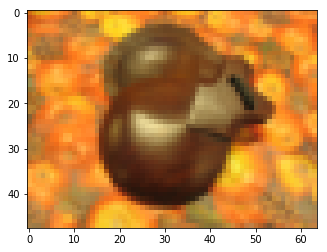

(48, 64)


In [33]:
im = array(Image.open('music.JPG'))
im = imresize(im, 0.1, interp='bilinear')
size = im.shape[:2]
figure()
imshow(im)
show()
print size

In [34]:
labels = zeros(size)
labels[10:35, 20:40] = 1
labels[:, :10] = -1
labels[:, -8:] = -1

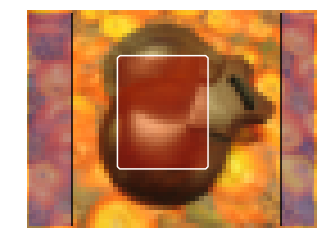

In [35]:
figure()
graphcut.show_labeling(im, labels)
show()

In [36]:
def build_bayes_graph(im, labels, sigma=1e-2, kappa=2):
    """ Build a graph from 4-neighborhood of pixels.
    Foregraound and background is determined from
    labels (1 for foreground, -1 for background, 0 othewise)
    and is modeled with naive Bayes classifiers. """

    m, n = im.shape[:2]

    # RGB vector version (one pixel per row)
    vim = im.astype('float')
    vim = vim.reshape((-1, 3))

    # RGB for foreground and background
    foreground = im[labels == 1].reshape((-1, 3))
    background = im[labels == -1].reshape((-1, 3))
    train_data = [foreground, background]

    # train naive Bayes classifier
    bc = bayes.BayesClassifier()
    bc.train(train_data, labels)

    # get probabilities for all pixels
    bc_lables, prob = bc.classify(vim)
    prob_fg = prob[0]
    prob_bg = prob[1]

    # create graph with m*n+2 nodes
    gr = digraph()
    gr.add_nodes(range(m*n+2))

    source = m*n  # second to last is source
    sink = m*n+1  # last node is sink

    # normalize
    pos = m*n/2-100
    for i in range(vim.shape[0]):
        vim[i] = vim[i] / linalg.norm(vim[i])

    # go through all nodes and add edges
    for i in range(m*n):
        # add edge from source
        if (prob_fg[i]>prob_bg[i]):
            gr.add_edge((source, i), wt=((prob_fg[i]-prob_bg[i])/(prob_fg[i] + prob_bg[i])))
        else:
            # add edge to sink
            gr.add_edge((i, sink), wt=((prob_bg[i]-prob_fg[i])/(prob_fg[i] + prob_bg[i])))
            
        # add edges to neighbors
        if i % n != 0:  # left exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-1])**2)/sigma)
            gr.add_edge((i, i-1), wt=edge_wt)
        if (i+1) % n != 0:  # right exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+1])**2)/sigma)
            gr.add_edge((i, i+1), wt=edge_wt)
        if i//n != 0:  # up exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-n])**2)/sigma)
            gr.add_edge((i, i-n), wt=edge_wt)
        if i//n != m-1:  # down exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+n])**2)/sigma)
            gr.add_edge((i, i+n), wt=edge_wt)
            
    return gr


In [37]:
import time

In [38]:
# Reduced version. Each pixel has only one link either to source or to sink
start = time.time()
g = build_bayes_graph(im, labels, kappa=1)
res = graphcut.cut_graph(g, size)
end = time.time()
print end - start, 's'

140.218219995 s


In [39]:
# Reduced version. Each pixel has only one link either to source or to sink
start = time.time()
g2 = graphcut.build_bayes_graph(im, labels, kappa=1)
res2 = graphcut.cut_graph(g2, size)
end = time.time()
print end - start, 's'

722.703329802 s


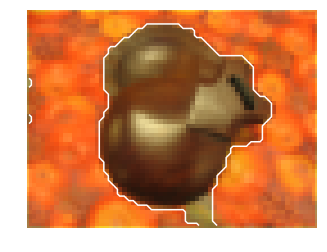

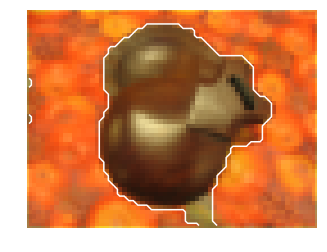

In [40]:
figure()
graphcut.show_labeling(im, res)
show()

figure()
graphcut.show_labeling(im, res2)
show()

In [48]:
seg = array(Image.open('music.bmp'))
seg = imresize(seg, 0.1, interp='nearest')

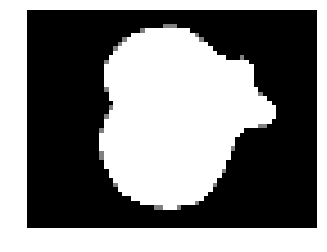

(48, 64)


In [77]:
figure()
imshow(seg)
axis('off')
show()
print seg.shape

In [92]:
def score_match(rin, sin):
    r = rin.flatten().copy()
    s = sin.flatten().copy()
    s[s==0] = 1
    s[s==255] = 0
    score = sum(1.0*(r==s))/r.shape[0]
    return score

In [94]:
print score_match(res, seg)

0.962565104167


In [95]:
print score_match(res2, seg)

0.962565104167
